# Applying Parameter-Efficient Fine-Tuning (PEFT) to a Large Language Model (LLM) in a Text Classification Task

This notebook is published in [https://github.com/mxagar/llm_peft_fine_tuning_example](https://github.com/mxagar/llm_peft_fine_tuning_example).

### Setup

To install all the dependencies, once you have your own Python environment (e.g., set with conda), you can use [`pip-tools`](https://pypi.org/project/pip-tools/) as follows:

```bash
# Install pip-tools
pip install -U pip-tools

# Compile dependencies: requirements.txt is generated/updated
pip-compile requirements.in

# Install/synchronize pinned dependencies with generated/updated requirements.txt
pip-sync requirements.txt
```

### Contents

The HuggingFace library `transformers` in combination with `peft` makes it very easy to fine-tune Large Language Models (LLMs) for our specific tasks.
This notebook shows how to use those libraries end-to-end to perform a text classification task.

Specifically:

- We use the [`ag_news`](https://huggingface.co/datasets/fancyzhx/ag_news) dataset, which consists of 120k news texts, each of them with a label related to its associated topic: `'World', 'Sports', 'Business', 'Sci/Tech'`.
- The [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) model is fine-tuned for the news classification task. In the process, [Low-Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685) is used to accelerate the fine-tuning thanks to the [`peft`](https://github.com/huggingface/peft) library.

Table of contents:

- [Dataset](#dataset)
  - [Custom Datasets](#custom-datasets)
  - [HuggingFace Datasets](#huggingface-datasets)
- [Preprocessing the Dataset](#preprocessing-the-dataset)
  - [Tokenization](#tokenization)
- [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
  - [Basic Exploration](#eda-basic-exploration)
  - [Feature Maps](#eda-feature-maps)
- [Model Setup](#model-setup)
- [Training](#training)
  - [Tensorboard](#tensorboard)
- [Prediction and Evaluation](#prediction-and-evaluation)
  - [Predict Interface with Model](#predict-interface-with-model)
  - [Merge, Save & Load Model](#merge-save--load-model)
- [Error Analysis](#error-analysis)
- [Packaging (ONNX) and Inference](#packaging-onnx-and-inference)

## Dataset

HuggingFace provides the module `dataset`, which enables handling our custom and already curated datasets from HuggingFace.

We will use the [`ag_news`](https://huggingface.co/datasets/fancyzhx/ag_news) from HuggingFace, however, a small comment on how to work with our own datasets is provided first. 

### Custom Datasets

Imagine our custom dataset is stored in a Python list:

```python
    news_data = [
        {
            "Headline": "President Signs New Climate Accord",
            "Summary": "The president has committed to new international environmental targets aimed at reducing emissions by 2030.",
            "Topic": "politics",
        },
        {
            "Headline": "Markets Rally After Interest Rate Cut",
            "Summary": "Stocks soared as the central bank announced a reduction in interest rates to stimulate economic growth.",
            "Topic": "economy",
        },
        #...
    ]
```

We can load it as a dataset as follows:

```python
    from datasets import Dataset

    dataset = Dataset.from_list(dummy_news)
```

Similarly, if we have a CSV file with the text and class items, we can load is as follows:

```python
    from datasets import Dataset

    dataset = load_dataset("csv", data_files=dummy_news_filepath)["train"]
```

### HuggingFace Datasets

In [ ]:
from datasets import load_dataset, DatasetDict

# Load the ag_news dataset
# See: https://huggingface.co/datasets/fancyzhx/ag_news
# This downloads the data to the default cache directory
# ~/.cache/huggingface/datasets
# and loads all the items contained in it into a Dataset object
dataset = load_dataset("fancyzhx/ag_news")

In [ ]:
# The ag_news has 2 splits: train and test
# We will create a new validation split from train
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [40]:
# Split 10% of train as validation
split_dataset = dataset["train"].train_test_split(
    test_size=0.1,
    stratify_by_column="label",
    seed=42,
)


In [41]:
dataset = DatasetDict({
    "train": split_dataset["train"],
    "validation": split_dataset["test"],
    "test": dataset["test"],
})

In [ ]:
# Now we have 3 splits: train, validation and test
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 108000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [43]:
splits = list(dataset.keys())  # ['train', 'test', 'validation']
print(f"Splits: {splits}")

Splits: ['train', 'validation', 'test']


In [44]:
print(dataset["train"].shape)
print(dataset["test"].shape)
print(dataset["train"].features)
print(dataset["train"].column_names)
print(dataset["train"][0])

(108000, 2)
(7600, 2)
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)}
['text', 'label']
{'text': 'Three tied for lead at Southern Farm Bureau Classic John Senden carded a pair of eagles, Harrison Frazar shot a 31 on the front nine and Glen Day recorded seven birdies to finish Thursday #39;s first round of the ', 'label': 1}


In [45]:
# Get the label features
print(dataset["train"].features["label"])

ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)


In [ ]:
# Label string <-> int mapping
# https://huggingface.co/datasets/fancyzhx/ag_news
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}

## Preprocessing the Dataset

Preprocessing consists mainly in tokenizing the texts, i.e., splitting the sentence words into numerical representations that can be ingested by a model.
Basically, the tokenizer has a vocabulary table in which each token is associated to an integer.

Since we are going to use [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert)), we need to preprocess the texts with the tokenizer associated with that model. That tokenizer is a *subword* tokenizer, which has learned to optimally partition the words into smaller pieces and has built a vocabulary out of all detected pieces.

### Tokenization

In [47]:
from transformers import AutoTokenizer

In [ ]:
# Load a tokenizer for the ag_news dataset
# We should use a tokenizer that matches the model we want to use later
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [49]:
print(f"Vocabulary size: {tokenizer.vocab_size}") # 30k tokens
print(f"Context length: {tokenizer.model_max_length}") # 512 tokens

Vocabulary size: 30522
Context length: 512


In [50]:
# We get back a dictionary with the encoded text:
# # {'input_ids': [...], 'attention_mask': [...]}
# The input_ids are the tokenized text ids (integers), and the attention_mask indicates which tokens are padding 
# (1: not padding, 0: padding -> ignore)
text = "This is a test message. I hope it works well!"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 2023, 2003, 1037, 3231, 4471, 1012, 1045, 3246, 2009, 2573, 2092, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [51]:
# We see that the the input ids map to the vocabulary of the tokenizer
# Subword tokenization is used.
# Special tokens are added, such as [CLS] and [SEP] for BERT-like models.
# [CLS] is the classification token (always in the beginning), and [SEP] is the separator token.
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))

['[CLS]', 'this', 'is', 'a', 'test', 'message', '.', 'i', 'hope', 'it', 'works', 'well', '!', '[SEP]']
[CLS] this is a test message. i hope it works well! [SEP]


In [52]:
# Tokenize the dataset in a dictionary format
# We add to the dataset the columns input_ids and attention_mask
tokenized_dataset = {}
for split in splits:
    # We can also use padding="max_length", which pads to tokenizer.model_max_length
    # or padding=True, which pads to the longest sequence in the batch
    # Truncation is always tokenizer.model_max_length
    # NOTE: Padding slows the training considerably
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x["text"], truncation=True), batched=True
    )

# Set the format of the dataset to PyTorch tensors
tokenized_dataset["train"].set_format("torch")
tokenized_dataset["test"].set_format("torch")

Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [53]:
# Check sizes and features/columns of tokenized datasets
print(tokenized_dataset["train"])
print(tokenized_dataset["train"].column_names)
print(tokenized_dataset["test"])
print(tokenized_dataset["test"].column_names)
print(tokenized_dataset["validation"])
print(tokenized_dataset["validation"].column_names)

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 108000
})
['text', 'label', 'input_ids', 'attention_mask']
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 7600
})
['text', 'label', 'input_ids', 'attention_mask']
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 12000
})
['text', 'label', 'input_ids', 'attention_mask']


## Exploratory Data Analysis (EDA)

It always makes sense to know our dataset better :-)

### Basic Exploration

Basic Exploratory Data Analysis:

- Are there duplicates or empty texts?
- How is the label distribution?
- How is the text length distribution for each class?
- Which are the most frequent words?

In [54]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [55]:
# Create DataFrames from the tokenized datasets
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])
df_validation = pd.DataFrame(dataset["validation"])
df_train["split"] = "train"
df_test["split"] = "test"
df_validation["split"] = "validation"
df = pd.concat([df_train, df_test, df_validation], ignore_index=True)
df["label_name"] = df["label"].map(id2label)

In [56]:
df.head()

,text,label,split,label_name
0,Three tied for lead at Southern Farm Bureau Cl...,1,train,Sports
1,"Current Woes Aside, Cisco Getting Ready For Ne...",3,train,Sci/Tech
2,NK Faces Severe Environmental Problems: UN Pol...,3,train,Sci/Tech
3,"No baloney, Rooney #39;s the real deal WE SHOU...",1,train,Sports
4,Stocks Dip as Dollar Rises and Oil Drops (Reut...,2,train,Business


In [57]:
# Look for duplicated and empty messages
print("Empty messages:", df["text"].str.strip().eq("").sum())
print("Duplicate messages:", df["text"].duplicated().sum())

Empty messages: 0
Duplicate messages: 0


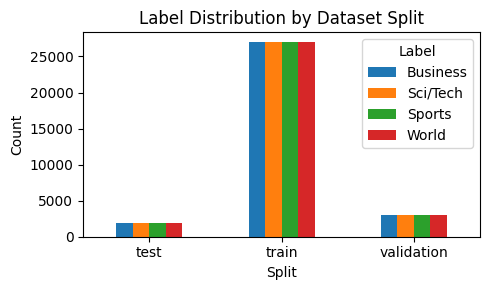

In [58]:
# Count occurrences of each label per split
label_counts_by_split = df.groupby(["split", "label_name"]).size().unstack(fill_value=0)

# Plot
label_counts_by_split.plot(kind="bar", figsize=(5, 3))
plt.title("Label Distribution by Dataset Split")
plt.xlabel("Split")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Label")
plt.tight_layout()
plt.show()

C:\Users\A200239740\AppData\Local\Temp\ipykernel_5060\1847797599.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(label_names))


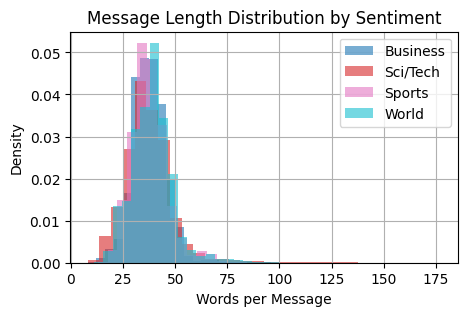

In [ ]:
# Compute text lengths for each label
label_names = df["label_name"].unique()
colors = plt.cm.get_cmap("tab10", len(label_names))

plt.figure(figsize=(5, 3))
for i, label_name in enumerate(sorted(label_names)):
    lengths = df[df["label_name"] == label_name]["text"].str.split().apply(len)
    plt.hist(lengths, bins=30, alpha=0.6, label=label_name, color=colors(i), density=True)

plt.title("Message Length Distribution by Sentiment")
plt.xlabel("Words per Message")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

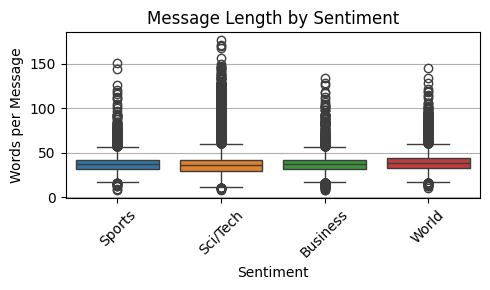

In [60]:
# Ensure message length is computed
df["length"] = df["text"].str.split().apply(len)

# Updated boxplot without deprecation warning
plt.figure(figsize=(5, 3))
sns.boxplot(
    x="label_name",
    y="length",
    hue="label_name",   # Assign hue explicitly
    data=df,
    palette="tab10",
    legend=False        # Prevent duplicate legend
)

plt.title("Message Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Words per Message")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

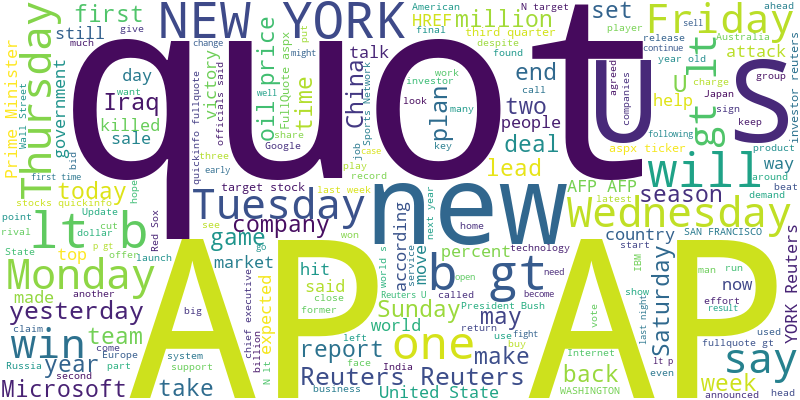

In [61]:
# Combine all text from the dataset
all_text = " ".join(df["text"].dropna())

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text).to_image()
wordcloud

### Feature Maps

If we are going to implement a text classification application, we can understand the pretrained LLM as a feature extractor. Since the LLMs output a sequence of hidden states, it is a usual convention to pick the first token/element as the `[CLS]` token/element. This will be a hidden vector of a given size and can be used for classification.

This section extracts the hidden states of the texts and maps them to a 2D space. Then, a hexplot is shown for each class, to see if there are visually discernible differences between class groups.

Note that the output vector of the model will be `(batch_size, seq_len, hidden_size)`; in the particular case of DistilBERT: `hidden_size = 768`.

In [62]:
from transformers import AutoModelForSequenceClassification
import torch

from umap import UMAP
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [63]:
def extract_hidden_states(batch, model, tokenizer, device="cpu"):
    # Filter only inputs required by the model
    # tokenizer.model_input_names: ['input_ids', 'attention_mask']
    input_batch = {k: batch[k] for k in tokenizer.model_input_names if k in batch}
    
    # Some models (e.g., GPT-2) do not have a pad token, so we set it to the eos token
    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Pad and convert to tensors
    inputs = tokenizer.pad(input_batch, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass with no gradient computation and output hidden states
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Extract [CLS] token embedding from last hidden state
    last_hidden_state = outputs.hidden_states[-1]
    cls_embeddings = last_hidden_state[:, 0].cpu().numpy()

    return {"hidden_state": cls_embeddings.tolist()}

In [ ]:
# Transformer model to extract hidden states
# We should get a warning about the model weights not being initialized for some layers
# This is because we have appended the classifier head and we haven't trained the model yet
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(id2label),
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
# Apply/map the extract_hidden_states function to the tokenized dataset
# This will create a new column in the dataset with the hidden states
tokenized_dataset_hidden_train = tokenized_dataset["validation"].map(
    lambda batch: extract_hidden_states(batch, model, tokenizer, device="cpu"),
    batched=True,
    batch_size=32,
)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [66]:
# Check new column is there
tokenized_dataset_hidden_train.column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [67]:
# Convert the hidden states to numpy arrays for further processing
X_train = np.array(tokenized_dataset_hidden_train["hidden_state"])
y_train = np.array(tokenized_dataset_hidden_train["label"])
print(X_train.shape)

(12000, 768)


In [68]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Adding noise to prevent initialization issues with UMAP
X_scaled += np.random.normal(scale=1e-4, size=X_scaled.shape)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine", init="random").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,6.008489,3.643164,2
1,3.071080,3.349994,0
2,5.461303,5.078278,2
3,7.544749,7.798629,3
4,5.479503,7.047376,2


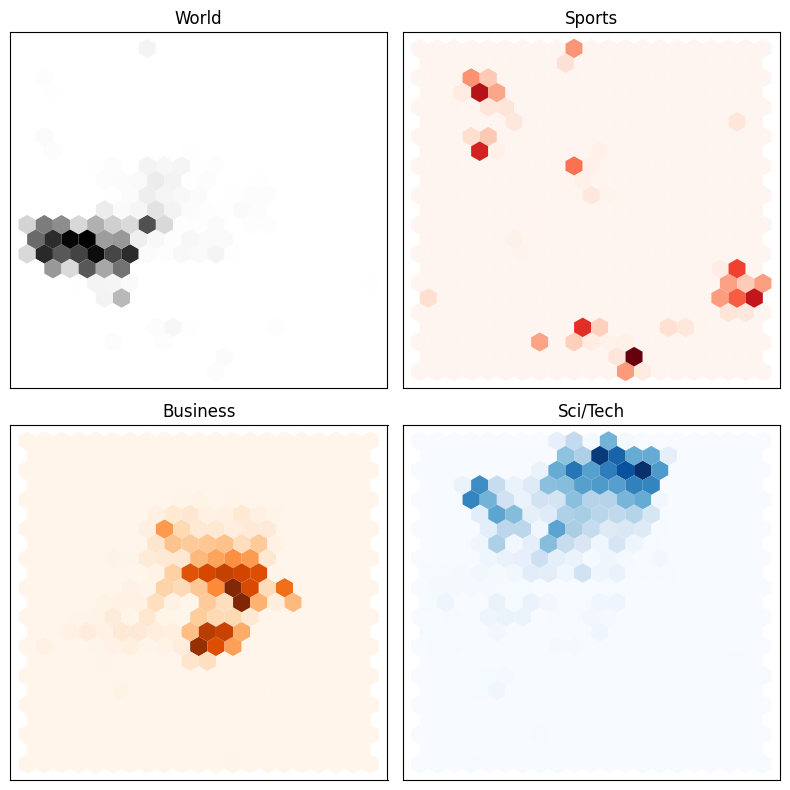

In [135]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
axes = axes.flatten()
cmaps = ["Greys", "Reds", "Oranges", "Blues"]

labels = tokenized_dataset["train"].features["label"].names  # ['negative', 'neutral', 'positive']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

## Model Setup

In [136]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, TaskType
from transformers import BitsAndBytesConfig
from peft import get_peft_model

In [137]:
# Quantization config (4-bit for minimal memory usage)
# WARNING: This requires the `bitsandbytes` library to be installed 
# and Intel CPU and/or 'cuda', 'mps', 'hpu', 'xpu', 'npu'
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Activate 4-bit quantization
    bnb_4bit_use_double_quant=True,         # Use double quantization for better accuracy
    bnb_4bit_compute_dtype="bfloat16",      # Use bf16 if supported, else float16
    bnb_4bit_quant_type="nf4",              # Quantization type: 'nf4' is best for LLMs
)

# Transformer model: we re-instantiate it to apply LoRA
# We should get a warning about the model weights not being initialized for some layers
# This is because we have appended the classifier head and we haven't trained the model yet
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
    #quantization_config=bnb_config,
    device_map="auto"  # Optional: distributes across GPUs if available
)

# LoRA configuration
# We need to check the target modules for the specific model we are using (see below)
# - For distilbert-base-uncased, we use "q_lin" and "v_lin" for the attention layers
# - For bert-base-uncased, we would use "query" and "value"
# The A*B weights are scaled with lora_alpha/r
lora_config = LoraConfig(
    r=16,                                   # Low-rank dimensionality
    lora_alpha=32,                          # Scaling factor
    target_modules=["q_lin", "v_lin"],      # distilbert-base-uncased: Which submodules to apply LoRA to (name depends on model, see below)
    lora_dropout=0.1,                       # Dropout for LoRA layers
    bias="none",                            # Do not train bias
    task_type=TaskType.SEQ_CLS              # Task type: sequence classification
)

# Freeze all the model parameters
# THIS IS NOT REALLY NECESSARY IF WE CALL get_peft_model()!
for param in model.parameters():
    param.requires_grad = False

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [138]:
# Get the PEFT model with LoRA
lora_model = get_peft_model(model, lora_config)

In [139]:
# If we need to know the target_modules of the LoraConfig, we can try this:
names = []
for name, _ in model.named_modules():
    if "query" in name or "q" in name or "attn" in name:
        names.append(str(name))


In [140]:
names[:5]

['distilbert.transformer.layer.0.attention.q_lin',
 'distilbert.transformer.layer.0.attention.q_lin.base_layer',
 'distilbert.transformer.layer.0.attention.q_lin.lora_dropout',
 'distilbert.transformer.layer.0.attention.q_lin.lora_dropout.default',
 'distilbert.transformer.layer.0.attention.q_lin.lora_A']

## Training

In [141]:
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [142]:
# Define the metrics we'd like to have
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if labels is None:
        return {}

    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [143]:
# Define training arguments
training_args = TrainingArguments(
    learning_rate=2e-3,
    weight_decay=0.01,
    num_train_epochs=1,
    #eval_strategy="epoch",  # alternatively "steps" and add argument eval_steps=200
    #save_strategy="epoch",  # alternatively "steps" and add argument save_steps=200
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=200,
    save_steps=200,
    # This seems to be a bug for PEFT models: we need to specify 'labels', not 'label'
    # as the explicit label column name
    # If we are not using PEFT, we can ignore this argument
    label_names=["labels"],  # explicitly specify label column name
    output_dir="./checkpoints",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    #metric_for_best_model="f1",  # loss is default
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="tensorboard",   # enable TensorBoard, if desired
)

# Initialize the Trainer
trainer = Trainer(
    model=lora_model,  # Transformer + Adapter (LoRA)
    #model=model,  # Transformer without Adapter (LoRA)
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

### Evaluation Pre-Fine-tuning

In [146]:
# Set the base model in the trainer to the LoRA model
trainer.model = model

In [ ]:
# Check base model performance on test split before training
# NOTE: the head is not trained
# F1: 16%
trainer.evaluate(tokenized_dataset["test"])

c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.3997029066085815,
 'eval_model_preparation_time': 0.0271,
 'eval_accuracy': 0.16592105263157894,
 'eval_precision': 0.16268472555524843,
 'eval_recall': 0.16592105263157897,
 'eval_f1': 0.15852320452677215,
 'eval_runtime': 493.003,
 'eval_samples_per_second': 15.416,
 'eval_steps_per_second': 0.963}

In [ ]:
# Set the PEFT/LoRA model to the Trainer
trainer.model = lora_model

In [ ]:
# Check PEFT model performance on test split before training
# NOTE: (1) the head is not trained, (2) the adapters (LoRA) are not trained
# F1: 24%
trainer.evaluate(tokenized_dataset["test"])

c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 1.3855674266815186,
 'eval_model_preparation_time': 0.0052,
 'eval_accuracy': 0.28986842105263155,
 'eval_precision': 0.24097303533979117,
 'eval_recall': 0.28986842105263155,
 'eval_f1': 0.2397676655368827,
 'eval_runtime': 418.4278,
 'eval_samples_per_second': 18.163,
 'eval_steps_per_second': 1.135}

### Train the PEFT Model

In [105]:
# TRAIN!
trainer.train()

c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
200,No log,0.413696,0.005200,0.861167,0.876719,0.861167,0.862800
400,No log,0.336035,0.005200,0.886500,0.886349,0.886500,0.885724
600,0.414000,0.328145,0.005200,0.893000,0.893191,0.893000,0.892814
800,0.414000,0.347036,0.005200,0.887917,0.887809,0.887917,0.887185
1000,0.400300,0.383080,0.005200,0.879500,0.882699,0.879500,0.879620
1200,0.400300,0.417792,0.005200,0.876167,0.883184,0.876167,0.876375
1400,0.400300,0.437209,0.005200,0.868250,0.874139,0.868250,0.866669
1600,0.448000,0.421210,0.005200,0.881167,0.883700,0.881167,0.880525
1800,0.448000,0.362125,0.005200,0.887667,0.889596,0.887667,0.888066
2000,0.389500,0.349787,0.005200,0.883583,0.886054,0.883583,0.883849


c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings

TrainOutput(global_step=6750, training_loss=0.37439413565176505, metrics={'train_runtime': 38711.3755, 'train_samples_per_second': 2.79, 'train_steps_per_second': 0.174, 'total_flos': 2772863010301440.0, 'train_loss': 0.37439413565176505, 'epoch': 1.0})

### Tensorboard

Tensorboard logs can be checked as follows (also while training):

```bash
    cd .../llm_peft_fine_tuning_example
    tensorboard --logdir=./logs
    # Then open http://localhost:6006 in the browser
```

## Prediction and Evaluation

In [ ]:
# We can always predict with the trainer
output = trainer.predict(tokenized_dataset["test"])
print(output.predictions[:5])
print(output.label_ids[:5])
print(output.metrics)

c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[[ 0.12032312 -4.3037043   2.31802    -2.715311  ]
 [-1.9054731  -4.5207233  -1.7523522   3.4816058 ]
 [-1.1825545  -4.12685    -1.6168176   2.8389237 ]
 [ 0.35077    -0.78827506 -2.3695793   1.0006979 ]
 [ 0.507651   -5.099419   -1.4975523   2.0962377 ]]
[2 3 3 3 3]
{'test_loss': 0.29908081889152527, 'test_model_preparation_time': 0.0052, 'test_accuracy': 0.901578947368421, 'test_precision': 0.9021632311160962, 'test_recall': 0.901578947368421, 'test_f1': 0.9013373057314664, 'test_runtime': 415.9215, 'test_samples_per_second': 18.273, 'test_steps_per_second': 1.142}


In [ ]:
# And we have also the evaluate() method to get the metrics on the test set
# F1: 90%
metrics = trainer.evaluate(tokenized_dataset["test"])
print(metrics)

c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.29908081889152527, 'eval_model_preparation_time': 0.0052, 'eval_accuracy': 0.901578947368421, 'eval_precision': 0.9021632311160962, 'eval_recall': 0.901578947368421, 'eval_f1': 0.9013373057314664, 'eval_runtime': 392.3436, 'eval_samples_per_second': 19.371, 'eval_steps_per_second': 1.211, 'epoch': 1.0}


### Predict Interface with Model

In [108]:
from typing import Dict, Any, Optional

# Complementary Inference Interface
# We can extract the model from the trainer and use it for inference
def predict(text: str, model: Any, tokenizer: Any, label_mapping: Optional[Dict], device: str ="cpu"):
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = logits.argmax(dim=-1).item()

    # Map back to label if mapping provided
    if label_mapping:
        return label_mapping[predicted_class_id]
    else:
        return predicted_class_id

In [132]:
texts = [
    "Markets rise to new highs.",  # Business
    "Apple presents new AppleCar",  # Sci/Tech
]
model = lora_model.eval()
pred = predict(texts[0], model, tokenizer, id2label, device="cpu")
print(pred)

Business


In [133]:
model = lora_model.eval()
pred = predict(texts[1], trainer.model, tokenizer, id2label, device="cpu")
print(pred)

Sci/Tech


### Merge, Save & Load Model

In [ ]:
# If we save the PEFT model without merging, only the adapter weights are saved
# ./distilbert-model-news
#     adapter_config.json
#     adapter_model.safetensors
#     README.md
lora_model.save_pretrained("distilbert-model-news")

In [ ]:
# If we have saved only the adapter weights, we can load the model with the adapter
from transformers import AutoModelForSequenceClassification
from peft import PeftModel
# Load the base model and then the adapter weights
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)
# Load the adapter weights
lora_model = PeftModel.from_pretrained(model, "distilbert-model-news")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Another option: AutoPeftModelForSequenceClassification
# We do not 
from peft import AutoPeftModelForSequenceClassification
lora_model = AutoPeftModelForSequenceClassification.from_pretrained("distilbert-model-news")

In [113]:
# Merge/Unmerge adapter weights to base model
# Merging the adapter weights into the base model
# will overwrite the base model weights with the adapter weights
# so the inference will be faster
# BUT the adapter weights remain in memory, so we can unmerge them
lora_model.merge_adapter()
lora_model.unmerge_adapter()

In [114]:
# Merge LoRA weights into the base model and remove adapter weights
# In this case, unmerging is not possible, unless we have saved the adapter weights separately
model = lora_model.merge_and_unload()

In [ ]:
# Now, we save the model with the merged weights
# ./distilbert-model-news
#     config.json
#     model.safetensors
model.save_pretrained("distilbert-model-news")

In [116]:
# If save the base model with the merged adapter weights,
# we can load it directly without the need of PEFT
from transformers import AutoModelForSequenceClassification
# Load the fine-tuned model with the already merged the adapter weights
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-model-news",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [117]:
# Initialize the Trainer for evaluation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [118]:
# Check how the model performs on the test set after loading
trainer.evaluate(tokenized_dataset["test"])

c:\Users\A200239740\AppData\Local\anaconda3\envs\peft\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.29908081889152527,
 'eval_model_preparation_time': 0.0,
 'eval_accuracy': 0.901578947368421,
 'eval_precision': 0.9021632311160962,
 'eval_recall': 0.901578947368421,
 'eval_f1': 0.9013373057314664,
 'eval_runtime': 399.9567,
 'eval_samples_per_second': 19.002,
 'eval_steps_per_second': 1.188}

## Error Analysis

We can perform error analysis by mapping a loss computation function to the test dataset split.

In [119]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch: Any, model: Any, tokenizer: Any, device: str = "cpu"):
    # Filter only inputs required by the model
    # tokenizer.model_input_names: ['input_ids', 'attention_mask']
    input_batch = {k: batch[k] for k in tokenizer.model_input_names if k in batch}
    
    # Pad and convert to tensors
    inputs = tokenizer.pad(input_batch, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass with no gradient computation
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(
            output.logits, batch["label"].to(device), 
            reduction="none"
        )

    # Move outputs to CPU   
    return {
        "loss": loss.cpu().numpy(), 
        "predicted_label": pred_label.cpu().numpy()
    } 

In [120]:
# Apply/map the forward_pass_with_label function to the tokenized dataset
# This will create new columns in the dataset: loss, predicted_label
tokenized_dataset_loss_test = tokenized_dataset["test"].map(
    lambda batch: forward_pass_with_label(batch, model, tokenizer, device="cpu"),
    batched=True,
    batch_size=32,
)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [121]:
# These are all current columns, but we don't need all of them
tokenized_dataset_loss_test.column_names

['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label']

In [122]:
# One entry
tokenized_dataset_loss_test[0]

{'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.",
 'label': tensor(2),
 'input_ids': tensor([  101, 10069,  2005,  1056,  1050, 11550,  2044,  7566,  9209,  5052,
          3667,  2012,  6769,  2047,  8095,  2360,  2027,  2024,  1005,  9364,
          1005,  2044,  7566,  2007, 16654,  6687,  3813,  2976,  9587, 24848,
          1012,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]),
 'loss': tensor(0.1124),
 'predicted_label': tensor(2)}

In [123]:
# Transform the dataset into a pandas DataFrame for easier analysis
# select only the relevant columns
# and replace the label ids with their string names
tokenized_dataset_loss_test.set_format("pandas")
cols = ['text', 'label', 'loss', 'predicted_label']
df_test = tokenized_dataset_loss_test[:][cols]
df_test["label"] = df_test["label"].replace(id2label)
df_test["predicted_label"] = df_test["predicted_label"].replace(id2label)

In [124]:
df_test.head()

,text,label,loss,predicted_label
0,Fears for T N pension after talks Unions repre...,Business,0.112352,Business
1,The Race is On: Second Private Team Sets Launc...,Sci/Tech,0.010190,Sci/Tech
2,Ky. Company Wins Grant to Study Peptides (AP) ...,Sci/Tech,0.030026,Sci/Tech
3,Prediction Unit Helps Forecast Wildfires (AP) ...,Sci/Tech,0.544412,Sci/Tech
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,Sci/Tech,0.209010,Sci/Tech


In [125]:
# Sort the entries by descending loss, i.e., show the most misclassified entries first
pd.set_option("display.max_colwidth", None)
df_test.sort_values("loss", ascending=False).head(10)

,text,label,loss,predicted_label
912,Bryant Makes First Appearance at Trial (AP) AP - NBA star Kobe Bryant arrived at his sexual assault trial Monday as attorneys in the case who spent the weekend poring over questionnaires prepared to question potential jurors individually.,Sci/Tech,8.786127,Sports
3265,How to take the perfect penalty A sports psychologist says how footballers should prepare themselves for the high-pressure penalties.,Sci/Tech,8.527875,Sports
2833,"Man arrested for fatally stabbing elderly parents SAITAMA -- A middle-aged man who fatally stabbed his parents has been arrested, police said. Hideo Nakajima, an unemployed man from Soka, Saitama Prefecture, apparently called police shortly before 8 pm, Wednesday.",Sci/Tech,7.481023,World
4300,"City Series-ly wounded With the Yanks out of the World Series, the city #39;s economy loses out on at least \$40 million, according to studies by the controller #39;s office and other city agencies.",Sports,7.397201,Business
5686,"GAME UNDER FIRE Attacking police officers, racial slurs, bloody beatings of innocent bystanders ... is it really just a game? In four and a half minutes, 14-year-old Ryan Mason ran over a police officer, stole his gun and shot and killed three innocent bystanders.",Sci/Tech,7.130622,Sports
1956,Sandia Motor Speedway for Sale on eBay (AP) AP - And the race is off! Only 29 days and some odd hours left to place your bid on eBay to buy the Sandia Motor Speedway.,Sci/Tech,6.951712,Sports
1269,"Philippines mourns dead in Russian school siege The Philippines Saturday expressed quot;deepest sympathy quot; to the families of the dead in the Russian school siege on Friday, in which 322 people were killed when Russian troops stormed",Sci/Tech,6.944468,World
4540,"Miss Peru takes Miss World crown Twenty-year-old Miss Peru has been crowned Miss World in a southern Chinese resort town, as China looks to become the regular host of an event that would have once been deemed heretical by its Communist leaders.",Sports,6.785917,World
5841,"INSIDE INFO: Man Utd shares drop MAN UNITED #39;S share price has fallen by just over 2.5, less than expected after the resignation of Malcolm Glazer #39;s bankers JP Morgan.",Sports,6.773882,Business
3077,Brewers buyer expected to step out of the shadows Monday MILWAUKEE - Paul Attanasio says the story of his brother buying a baseball team is like a script straight out of Hollywood. He should know.,Business,6.770212,Sports


## Packaging (ONNX) and Inference

If we want to move to production, we could export the model as ONNX and implement a custom `predict_with_onnx()` function for inference.

Note: The tokenizer cannot be exported as ONNX, because it's not a neural network. The **best practice** consists in saving the tokenizer model along with the ONNX of the LLM. Then, we load the saved tokenizer. HuggingFace tokenizers are implemented in Rust, so they are very fast already.

In [126]:
from pathlib import Path
from typing import Tuple, Optional, Union
import numpy as np
import torch

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers.onnx import export
from transformers.onnx.features import FeaturesManager
import onnxruntime as ort

In [127]:
# Use the same tokenizer as during training
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Get the ONNX config constructor for distilbert (sequence classification)
feature = "sequence-classification"
model_kind = "distilbert"  # "bert"

# Build the ONNX config with correct architecture and config
onnx_config_cls = FeaturesManager.get_config(model_kind, feature=feature)
onnx_config = onnx_config_cls(model.config)  # model.config comes from our trained DistilBERT model

# Define ONNX export path
onnx_path = Path("distilbert-model-news-onnx")
onnx_path.mkdir(exist_ok=True)

# Export the merged model (classification head included)
export(
    preprocessor=tokenizer,
    model=model,  # This is your merged LoRA model
    config=onnx_config,
    opset=17,  # Use at least 14
    output=onnx_path / "model.onnx",
)

(['input_ids', 'attention_mask'], ['logits'])

In [128]:
def predict_with_onnx(
    session: ort.InferenceSession,
    tokenizer: transformers.BasicTokenizer,
    text: str,
    label_mapping: Optional[Dict] = None,
) -> Union[int, str]:
    # Tokenize input
    inputs = tokenizer(text, return_tensors="np", padding="max_length", truncation=True, max_length=128)

    # Run ONNX inference
    ort_inputs = {k: v for k, v in inputs.items() if k in [i.name for i in session.get_inputs()]}
    outputs = session.run(None, ort_inputs)

    # Get logits and predicted class
    logits = outputs[0]
    predicted_class = int(np.argmax(logits, axis=1)[0])

    if label_mapping is not None:
        predicted_class = label_mapping[predicted_class]

    return predicted_class

In [129]:
# Load ONNX model
onnx_filepath = onnx_path / "model.onnx"
session = ort.InferenceSession(onnx_filepath.as_posix(), providers=["CPUExecutionProvider"])

# Test
text = "Market closes with historic records."
pred_class = predict_with_onnx(session, tokenizer, text, id2label)
print(f"Predicted class: {pred_class}")

Predicted class: Business


In [130]:
from typing import Union, Dict
from tqdm import tqdm
import pandas as pd
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_with_onnx(
    session: ort.InferenceSession,
    tokenizer: transformers.PreTrainedTokenizer,
    dataset: Union[Dataset, pd.DataFrame],
    input_col: str = "text",
    target_col: str = "label",
) -> Dict[str, float]:
    # Ensure input is DataFrame
    if isinstance(dataset, Dataset):
        df = dataset.to_pandas()
    else:
        df = dataset

    # Run predictions
    preds = []
    targets = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating with ONNX"):
        pred = predict_with_onnx(
            session=session,
            tokenizer=tokenizer,
            text=row[input_col],
            label_mapping=None
        )
        preds.append(pred)
        targets.append(row[target_col])

    # Compute metrics
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, average="macro")
    rec = recall_score(targets, preds, average="macro")
    f1 = f1_score(targets, preds, average="macro")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

In [ ]:
# Run evaluation with ONNX model
metrics = evaluate_with_onnx(
    session=session,
    tokenizer=tokenizer,
    dataset=tokenized_dataset["test"],
    input_col="text",
    target_col="label",
)

print(metrics)

Evaluating with ONNX: 100%|██████████| 7600/7600 [09:04<00:00, 13.96it/s]

{'accuracy': 0.9014473684210527, 'precision': 0.902040505993592, 'recall': 0.9014473684210527, 'f1': 0.9012043579146146}
